# OFDM signal (High carrier frequency)

Install all dependencies

In [1]:
!pip install numpy matplotlib scipy

Import dependencies

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
from calculate_evm import calculate_evm
from resample_by_interpolation import resample_by_interpolation

Calculate modulation symbols (64QAM)

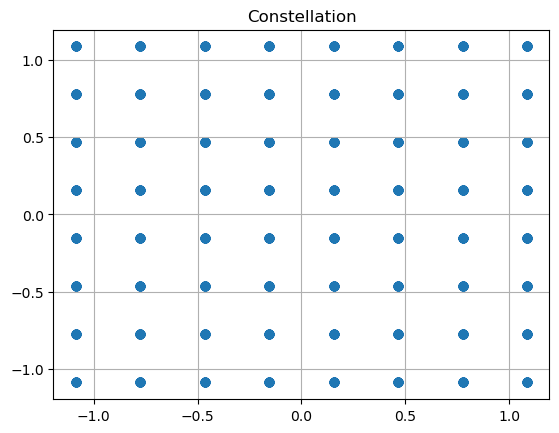

In [6]:
number_of_symbols = 2048
symbol_re = np.random.randint(0, 8, number_of_symbols) * 2 - 7
symbol_im = np.random.randint(0, 8, number_of_symbols) * 2 - 7
golden_symbols = symbol_re + 1.0j * symbol_im
golden_symbols = golden_symbols / np.sqrt(np.mean(np.abs(golden_symbols) ** 2))
plt.figure()
plt.grid()
plt.scatter(np.real(golden_symbols), np.imag(golden_symbols))
plt.title("Constellation")
plt.show()

Add noise

The calculated EVM = 7.12%


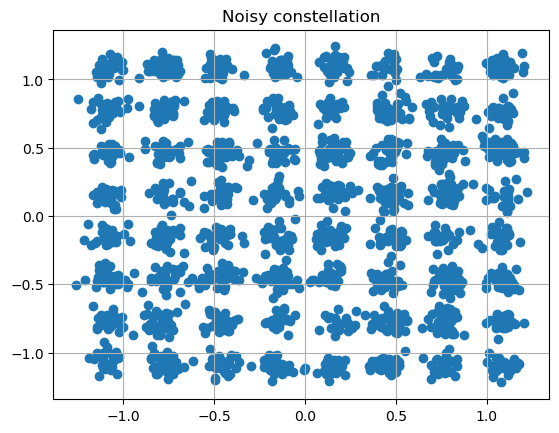

In [9]:
symbols = golden_symbols
add_noise = True
if add_noise:
    SNR_dB = 23
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = 1 / SNR_linear
    symbols = symbols + np.sqrt(noise_power / 2) * (np.random.randn(number_of_symbols) + 1.0j * np.random.randn(number_of_symbols))
    evm = calculate_evm(golden_symbols, symbols)
    print(f"The calculated EVM = {evm:.2f}%")
if add_noise:
    plt.figure()
    plt.grid()
    plt.scatter(np.real(symbols), np.imag(symbols))
    plt.title("Noisy constellation")
    plt.show()

Generate OFDM signal (ignoring CP)

In [10]:
ofdm = np.fft.ifft(symbols)

Perform digital upconversion to carrier frequency

In [11]:
subcarrier_spacing = 15e0
fs_bb = number_of_symbols * subcarrier_spacing
fc = 1e3 * fs_bb
fs = 2.1 * fc
interpolation_factor = fs / fs_bb
print(f"number of symbols = {number_of_symbols}, "
      f"subcarrier spacing = {subcarrier_spacing}Hz, "
      f"sampling frequency (baseband) = {fs_bb / 1e3:.2f}Hz, "
      f"carrier frequency = {fc / 1e6}MHz, "
      f"sampling frequency (carrier) = {fs / 1e6:.2f}MHz, "
      f"interpolation factor = {interpolation_factor}")
upsampled_ofdm = resample_by_interpolation(ofdm, 1, interpolation_factor)
print(f"number of samples before upsampling: {len(ofdm)}, "
      f"number of samples after upsampling: {len(upsampled_ofdm)}")
t = np.arange(len(upsampled_ofdm)) / fs
carrier_signal = np.exp(1.0j * 2 * np.pi * fc * t)
upconverted_signal = np.real(upsampled_ofdm * carrier_signal)

number of symbols = 2048, subcarrier spacing = 15.0Hz, sampling frequency (baseband) = 30.72Hz, carrier frequency = 30.72MHz, sampling frequency (carrier) = 64.51MHz, interpolation factor = 2100.0
number of samples before upsampling: 2048, number of samples after upsampling: 4300800


Perform digital downconversion using IQ sampling

In [12]:
downconverted_signal_i = upconverted_signal * np.cos(2 * np.pi * fc * t)
downconverted_signal_q = -upconverted_signal * np.sin(2 * np.pi * fc * t)
numtaps = 51
fcutoff = 1.1 * fs_bb
coeffs = firwin(numtaps, fcutoff, fs = fs)
downconverted_signal_i = lfilter(coeffs, 0.5, downconverted_signal_i)
downconverted_signal_q = lfilter(coeffs, 0.5, downconverted_signal_q)
downconverted_signal = downconverted_signal_i + 1.0j * downconverted_signal_q
downsampled_signal = resample_by_interpolation(downconverted_signal, interpolation_factor, 1)

Re-generate modulation symbols

Regenerated EVM = 7.26%


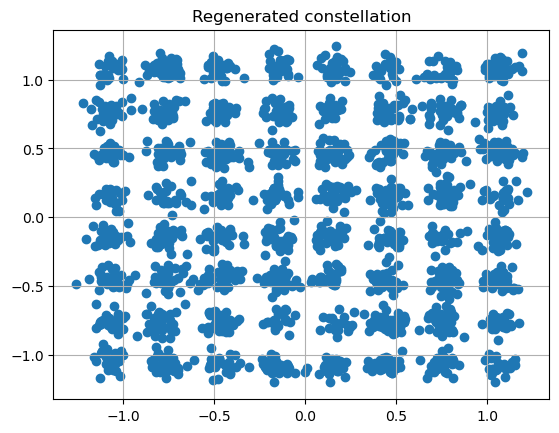

In [13]:
regenerated_symbols = np.fft.fft(downsampled_signal)
'''scaling_factor = np.sqrt(np.mean(np.abs(regenerated_symbols) ** 2 / np.abs(golden_symbols) ** 2))
print(f"scaling_factor = {scaling_factor:.2f}")'''
regenerated_evm = calculate_evm(golden_symbols, regenerated_symbols)
print(f"Regenerated EVM = {regenerated_evm:.2f}%")
plt.figure()
plt.grid()
plt.scatter(np.real(regenerated_symbols), np.imag(regenerated_symbols))
plt.title("Regenerated constellation")
plt.show()

All copyright reserved @2025 Ericsson